In [1]:
!pip install "tensorflow-gpu>=1.15.2,<2.0" ampligraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.0 MB 28 kB/s 
     |████████████████████████████████| 168 kB 64.9 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 503 kB 65.0 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 2.9 MB 36.0 MB/s 
     |████████████████████████████████| 3.8 MB 50.6 MB/s 
     |████████████████████████████████| 2.7 MB 49.0 MB/s 
     |████████████████████████████████| 500 kB 61.2 MB/s 
     |████████████████████████████████| 61 kB 580 kB/s 
     |████████████████████████████████| 6.4 MB 50.5 MB/s 
     |████████████████████████████████| 120 kB 72.1 MB/s 
     |████████████████████████████████| 561 kB 65.6 MB/s 
     |████████████████████████████████| 41 kB 465 kB/s 
     |████████████████████████████████| 61 kB 514 kB/s 
     |████████████████████████████████|

In [2]:
import numpy as np
import pandas as pd
import ampligraph
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ComplEx
from ampligraph.evaluation import evaluate_performance
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
from ampligraph.utils import save_model, restore_model

ampligraph.__version__

'1.4.0'

In [3]:
import tensorflow as tf

tf.test.is_gpu_available()

True

In [4]:
import rdflib
graph = rdflib.Graph()
graph.parse('pokemons_cut.owl', format='json-ld')
prefix = r'http://www.semanticweb.org/markus/ontologies/2022/9/pokemon'

In [10]:
def parse_triples():
    triples = []
    for s, p, o in graph.triples((None, None, None)):
        if p.startswith(rdflib.URIRef(prefix)):
            triples.append([ent.replace(prefix + "#", "poke:") for ent in [s, p, o]])
    df = pd.DataFrame(triples, columns=['Subject', 'Predicate', 'Object'])
    return df, triples

In [6]:
def split_train_test(triples):
    X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=2500)
    print('Train set size: ', X_train.shape)
    print('Test set size: ', X_test.shape)
    return X_train, X_test

In [7]:
def build_model(X_train, X_test):
    mdl = ComplEx(batches_count=50,
                  epochs=300,
                  k=100,
                  eta=20,
                  optimizer='adam',
                  optimizer_params={'lr': 1e-4},
                  loss='multiclass_nll',
                  regularizer='LP',
                  regularizer_params={'p': 3, 'lambda': 1e-5},
                  seed=0,
                  verbose=True)

    mdl.fit(X_train)

    filter_triples = np.concatenate((X_train, X_test))
    ranks = evaluate_performance(X_test,
                                 model=mdl,
                                 filter_triples=filter_triples,
                                 use_default_protocol=True,
                                 verbose=True)
    mr = mr_score(ranks)
    mrr = mrr_score(ranks)

    print("MRR: %.2f" % (mrr))
    print("MR: %.2f" % (mr))

    hits_10 = hits_at_n_score(ranks, n=10)
    print("Hits@10: %.2f" % (hits_10))
    hits_3 = hits_at_n_score(ranks, n=3)
    print("Hits@3: %.2f" % (hits_3))
    hits_1 = hits_at_n_score(ranks, n=1)
    print("Hits@1: %.2f" % (hits_1))
    save_model(mdl, model_name_path="pokemon.model")

In [11]:
df, triples = parse_triples()
train, test = split_train_test(triples)

Train set size:  (62982, 3)
Test set size:  (2500, 3)


In [12]:
build_model(train, test)

Average ComplEx Loss:   0.270421: 100%|██████████| 300/300 [02:46<00:00,  1.80epoch/s]

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.



100%|██████████| 2500/2500 [00:10<00:00, 246.49it/s]


MRR: 0.24
MR: 107.27
Hits@10: 0.39
Hits@3: 0.25
Hits@1: 0.17


In [13]:
!pip install adjustText

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from ampligraph.discovery import find_clusters
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

def clustering(df):

    mdl = restore_model("pokemon.model")
    pokemons = df.Subject[df.Subject.str.contains(r'poke:[A-Z].*-poke')].unique()
    pokemons_embeddings = dict(zip(pokemons, mdl.get_embeddings(pokemons)))
    pokemons_embeddings_array = np.array([i for i in pokemons_embeddings.values()])

    embeddings_2d = PCA(n_components=2).fit_transform(pokemons_embeddings_array)

    # Find clusters of embeddings using KMeans
    clustering_algorithm = KMeans(n_clusters=2, n_init=50, max_iter=500, random_state=0)
    clusters = find_clusters(pokemons, mdl, clustering_algorithm, mode='entity')

    # Plot results
    df = pd.DataFrame({"pokemons": pokemons, "clusters": "cluster" + pd.Series(clusters).astype(str),
                       "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

    plt.figure(figsize=(12, 12))
    plt.title("Cluster embeddings")

    ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

    # print(df.pokemons.values)

    texts = []
    for i, point in df.iterrows():
        if np.random.uniform() < 0.1:
            texts.append(plt.text(point['embedding1'] + .02, point['embedding2'], str(point['pokemons'])))
    adjust_text(texts)
    plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=aa7dadc31fbf6dd37fdd191914a31aeb239a7e39535de2cc875882f40f782dbd
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText


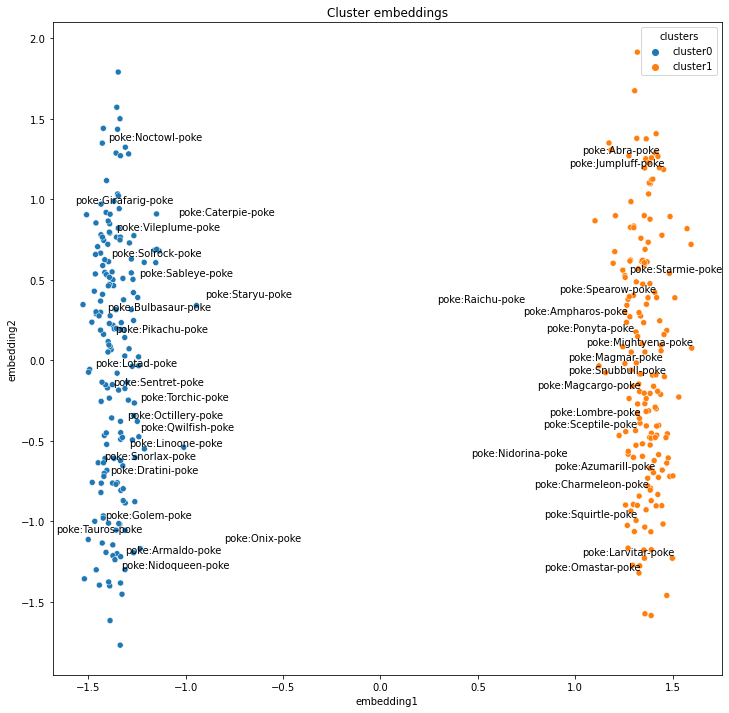

In [14]:
clustering(df)